In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import  List, Union, Type, Callable

%matplotlib inline

BIG_SEED = 3914379 #random seed for later

score_metric = 'accuracy'
label_metric = 'Accuracy'

In [2]:
df = pd.read_csv('data.csv')

In [3]:
print(len(df))
df.head()

100


,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2


In [4]:
#This way the rare class has value 1 (for the F-score)
df.Class = df.Class - 1

# Exercise 1

## GP with LCB and EI

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter,\
                                        UniformIntegerHyperparameter

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO #Random Forest
from smac.facade.smac_bo_facade import SMAC4BO   #GP
#from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer import acquisition

In [6]:
def optimizer(surrogate_model :str, 
              config_space :Type[ConfigurationSpace],
              obj_function :Type[Callable],
              acquisition_type :str,
              n_iter :int = 10,
              init_points :int = 0,
              seed :int=None) -> Union[Type[SMAC4BO], Type[SMAC4HPO]]:
    """
    It is just a small wrapper to simplify and make more intuitive 
    the SMAC optimization for ML algorithms for this assignment.
    PARAMETERS
    ----------
    @surrogate_model  can be 'gp' for GaussianProcess or 
                      'rf' for RandomForest
    @config_space     an object of type ConfigSpace containing 
                      information regarding the hyperparameters
    @obj_function     the objective function that needs to be minimized 
    @acquisition_type can be 'LCB', 'EI' or 'PI' and indicated the type 
                      of acquisition function to be used, if the value 
                      is different from 'LCB', 'EI' or 'PI' it will use 
                      the default acquisition function of SMAC.
    @n_iter           number of iterations to do, defaults to 10 iterations
    @init_points      number of initial points, defaults to 0 initial points
    @seed             fix the seed for most of the randomness to have 
                      reproducible results
    
    RETURN
    ------
    either an optimized SMAC4BO object if 'gp' model_type was chosen 
    or an optimized SMAC4HPO object if 'rf' model_type was chosen
    """
    #create the scenario required by SMAC optimizers
    #First we write down it's values in a dictionary and comment the results

    scen_dict = {"run_obj": "quality",    # we optimize quality
            #the only two choises are quality and runtime
            "runcount-limit": n_iter,# number iterations
            "cs": cs,      # configuration space
            "output_dir": "logs",    # create a log folder 
            #named 'logs' to save the logs of SMAC
            "deterministic": "true", #otherwise the model
            #may need to revaluate the same points more time
            #to be sure of the value at that specific point
            "abort_on_first_run_crash": True, #abort in case of a crash instead
            #of failing the model itself, this way the model doesn't crash
            "always_race_default": False
            }
    scenario = Scenario(scenario=scen_dict)
    #create init_points random points, fixing the seed if necessary
    cs.seed(seed)
    init = cs.sample_configuration(init_points)
    cs.seed(None) #remove the seed from configuration space
    
    #choose the acquisition function
    #only the one explained at the lessons are present here
    if acquisition_type == 'LCB':
        print('Using LCB acquisition Function')
        _acquistion = acquisition.LCB
    elif acquisition_type == 'EI':
        print('Using EI acquisition Function')
        _acquistion = acquisition.EI
    elif acquisition_type == 'PI':
        print('Using PI acquisition Function')
        _acquistion = acquisition.PI
    else:
        #use the defualt one chosen by SMAC based on the 
        #type of surrogate model chosen
        print('Using SMAC Default acquisition Function')
        _acquistion = None
        
    #choose and optimize the SMAC model
    if surrogate_model == 'gp':
        #use SMAC4BO
        smac = SMAC4BO(scenario=scenario, tae_runner=obj_function, 
                       rng=np.random.RandomState(seed),
                       initial_design=None, 
                       initial_design_kwargs={'max_config_fracs':init_points/n_iter},
                       initial_configurations=init, 
                       acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    if surrogate_model == 'rf':
        #use SMAC4HPO (Bayesian Optimization with Random Forest)
        smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function, 
                        rng=np.random.RandomState(seed),
                        initial_design=None, 
                        initial_design_kwargs={'max_config_fracs':init_points/n_iter},
                        initial_configurations=init, 
                        acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    #in case model_type was neither gp nor rf
    raise ValueError("Model type can only 'gp' or 'rf'")

In [7]:
#SMAC needs a Configuration Space where it will search for the hyperparameters
cs = ConfigurationSpace()

#define the domain of each hyperparameter
lr = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9)

#add the hyperparameters to the configuration space
cs.add_hyperparameters([lr, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [8]:
def MLP_score_1(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    MLPclf = MLPClassifier(hidden_layer_sizes=(4,2,), momentum = conf['momentum'],
                          learning_rate_init = conf['learning_rate_init'],
                          random_state=BIG_SEED)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score) #Error metric

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Using LCB acquisition Function


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.05237916904831544
  momentum, Value: 0.8078920990303289



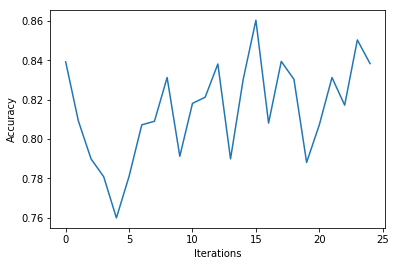

In [9]:
#Use gp and LCB
smac_LCB = optimizer('gp', cs, obj_function=MLP_score_1, 
                     acquisition_type='LCB', n_iter=25, 
                     init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_LCB.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Using EI acquisition Function


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1608
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.047688869198034764
  momentum, Value: 0.8018232055711371



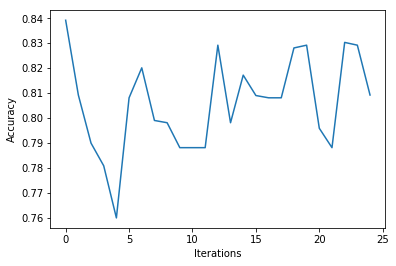

In [10]:
#Use gp and EI
smac_EI = optimizer('gp', cs, obj_function=MLP_score_1, 
                    acquisition_type='EI', n_iter=25, 
                    init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_EI.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

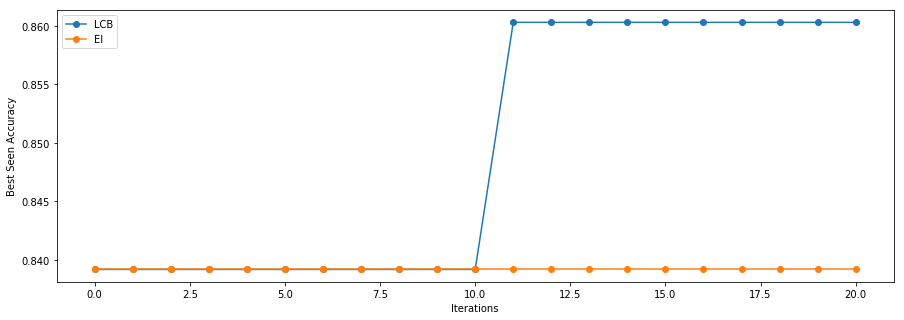

In [11]:
#Compare the two models removing the initial 5 points keeping only the best of them.
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1])[4:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1])[4:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

## Grid and Randomized Search

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time

In [13]:
#create the configuration grid with 5 element for each hyperparameter
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5)}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1) #n_jobs=-1 parallelize the computation

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'learning_rate_init': 0.01, 'momentum': 0.1}
Training Completed in 8.293s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score 0.85


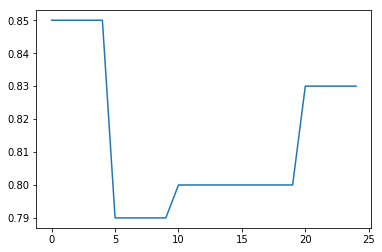

In [14]:
print("Best Score", np.max(MLP_GS.cv_results_['mean_test_score']))
plt.plot(MLP_GS.cv_results_['mean_test_score'])
plt.show()

In [15]:
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9)}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=25, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.4755102040816327, 'learning_rate_init': 0.019183673469387756}
Training Completed in 8.613s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score 0.86


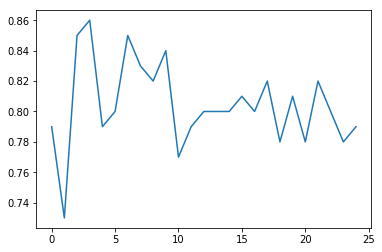

In [16]:
print("Best Score", np.max(MLP_RS.cv_results_['mean_test_score']))
plt.plot(MLP_RS.cv_results_['mean_test_score'])
plt.show()

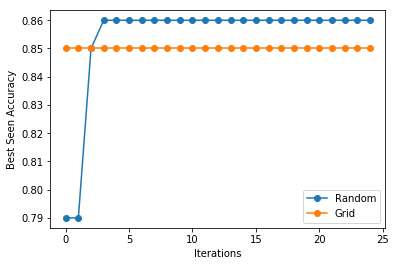

In [17]:
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

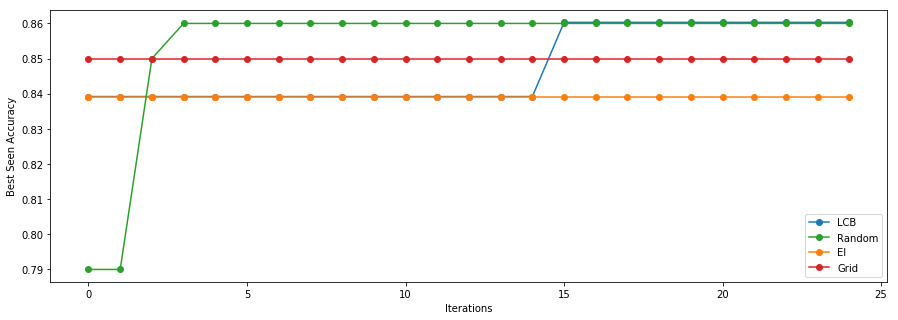

In [18]:
plt.figure(figsize=(15,5))
lcb, = plt.plot(1-np.minimum.accumulate(smac_LCB.get_X_y()[1]), 'o-')
ei,  = plt.plot(1-np.minimum.accumulate(smac_EI.get_X_y()[1]), 'o-')
rs,  = plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
gs,  = plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend([lcb,rs,ei,gs],['LCB','Random','EI','Grid']) #need to change order based on the score
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

# Exercise 2

## Random Forest with LBC and EI

In [19]:
hidden1 = UniformIntegerHyperparameter('h1',1,5)
hidden2 = UniformIntegerHyperparameter('h2',1,5)

cs.add_hyperparameters([hidden1, hidden2])

[h1, Type: UniformInteger, Range: [1, 5], Default: 3,
 h2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [20]:
def MLP_score_2(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    #rseed = int(conf['momentum']*conf['learning_rate_init']*5000)
    rseed = BIG_SEED
    MLPclf = MLPClassifier(hidden_layer_sizes=(conf['h1'],conf['h2'],), 
                           momentum = conf['momentum'],
                           learning_rate_init = conf['learning_rate_init'],
                           random_state=rseed)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    #print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score)  # it needs to Minimize it!

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Using EI acquisition Function


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  h1, Value: 5
  h2, Value: 4
  learning_rate_init, Value: 0.010607150307254926
  momentum, Value: 0.8210514567778897



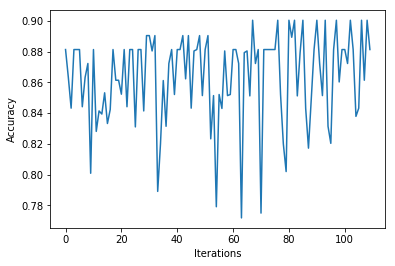

In [21]:
#Use rf and EI
smac_rf_EI = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='EI', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_rf_EI.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Using LCB acquisition Function


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0995) is better than incumbent (0.1186) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 3 -> 5
INFO:smac.intensification.intensification.Intensifier:  h2 : 1 -> 4
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.010539498061603514 -> 0.01523447967822237
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.3188882121911101 -> 0.5167126696109956
INFO:sma

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0995
INFO:smac.intensification.in

Best Configuration found:
Configuration:
  h1, Value: 5
  h2, Value: 4
  learning_rate_init, Value: 0.01523447967822237
  momentum, Value: 0.5167126696109956



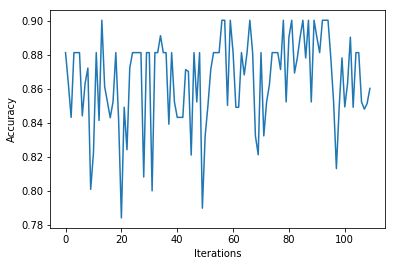

In [22]:
#Use rf and LCB
smac_rf_LCB = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='LCB', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
plt.plot(1 - smac_rf_LCB.get_X_y()[1])
plt.ylabel(label_metric)
plt.xlabel('Iterations')
plt.show()

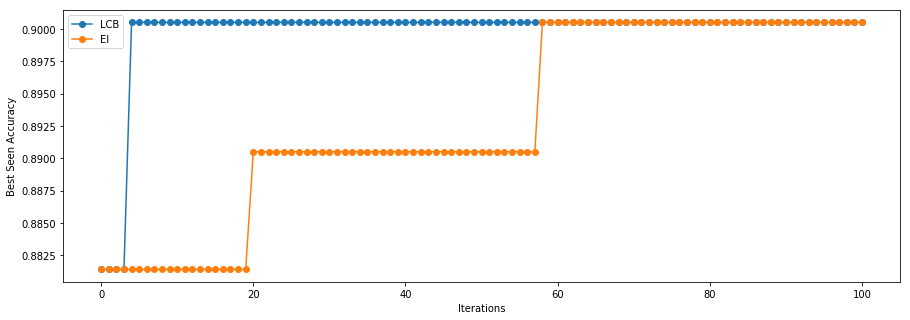

In [23]:
#Compare the two models removing the initial 5 points keeping only the best of them.
plt.figure(figsize=(15,5))
plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1])[9:], 'o-') #0,1,2,3,4 sono i punti iniziali
plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1])[9:], 'o-')
plt.legend(['LCB','EI'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

## Random and Grid Search

In [24]:
#create the configuration grid with 5 element for each hyperparameter
#We will obtain 125 iteration but during the plot we will plot only 
# the last 110 just so each model have the same lenght in terms of iterations.
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5),
             'hidden_layer_sizes':[(1,1), (1,5), (3,3), (5,1), (5,5)]}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_, "-> score", MLP_GS.best_score_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'hidden_layer_sizes': (1, 1), 'learning_rate_init': 0.01, 'momentum': 0.1} -> score 0.88
Training Completed in 27.760s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
hidden =[(i, j) for i in range(1,6) for j in range(1,6)]        
        
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9),
              'hidden_layer_sizes':hidden}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=110, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_, "-> score", MLP_RS.best_score_)
print("Training Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.7693877551020408, 'learning_rate_init': 0.08163265306122448, 'hidden_layer_sizes': (4, 4)} -> score 0.89
Training Completed in 24.104s


/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


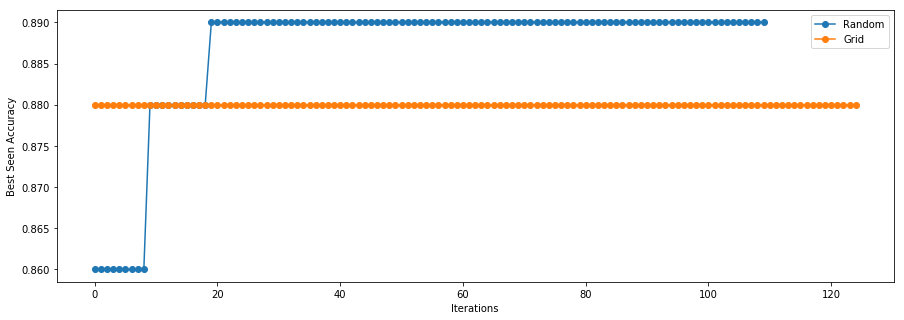

In [26]:
plt.figure(figsize=(15,5))
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

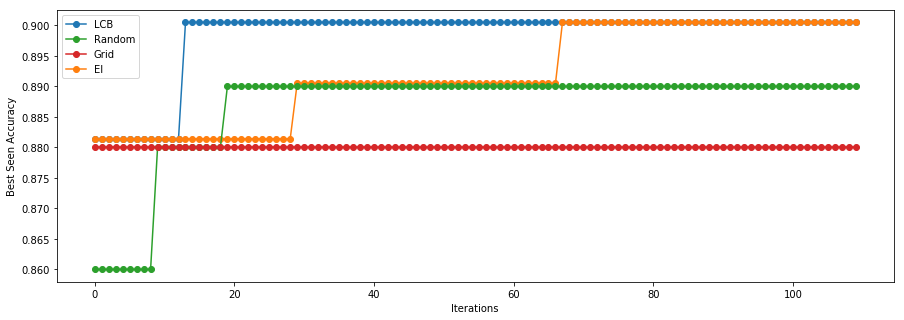

In [27]:
plt.figure(figsize=(15,5))
lcb, = plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1]), 'o-', label='LCB')
ei, = plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1]), 'o-', label='EI')
rs, = plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-', label='Random')
gs, = plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score'])[15:], 'o-', label='Grid')

plt.legend([lcb,rs,gs,ei], ['LCB','Random','Grid','EI'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()